## Argo Float Plotting

In this tutorial, we will show how to use visualise data from Argo Float deployment(s) in VirtualShip.

There are example plots embedded in this notebook, but these will ultimately be replaced by your own versions if you are working through the notebook with your own expedition output.

The plots will visualise the trajectories of the Argo floats released at one or more waypoint(s) of the expedition, in three dimensions (latitude, longitude, depth), and show the temperature or salinity fields being sampled.

### Set up

#### Imports

The first step is to import the Python packages required for post-processing the data and plotting. 

<div class="alert alert-block alert-success"> 
<b>Tip:</b> You may need to set the Kernel to the relevant (Conda) environment in the top right of this notebook to access the required packages! 
</div>

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import plotly.io as pio
from IPython.display import HTML

#### Data directory

Next, you should set `data_dir` to be the path to your expedition results in the code block below. You should replace `"/path/to/EXPEDITION/results/"` with the path for your machine.

<div class="alert alert-block alert-success"> 
<b>**TIP**:</b> You can get the path to your expedition results by navigating to the `results` folder in Terminal (using `cd`) and then using the `pwd` command. This will print your working directory which you can copy to the `data_dir` variable in this notebook. Don't forget to keep it as a string (in "quotation" marks)!
</div>

In [ ]:
# set data dir path

data_dir = "/path/to/EXPEDITION/results/"  # set this to be where your expedition output data is located on your (virtual) machine

#### Load data

We are now ready to read in the data using the `xarray` package. You can carry on executing the next cells without making changes to the code…

In [8]:
# load argo data

argo_ds = xr.open_dataset(f"{data_dir}/argo_float.zarr")

### Plotting

<div class="alert alert-block alert-info"> 
<b>**NOTE**:</b> The plots produced next are a starting point for your analysis. You are encouraged to make further adjustments and enhancements to suit your own data and research question.
</div>

As a first step, we will produce a simple 2D spatial plot of the Argo float(s): where they were released at each waypoint (black scatter marker(s)), and their trajectories (from a bird's eye view) as they move through the ocean (coloured lines). Bear in mind though the floats will also be moving vertically through the water column as they profile, which we will explore in later plots. For now, the locations where vertical profiles were taken are indicated by the red markers along the trajectory lines.

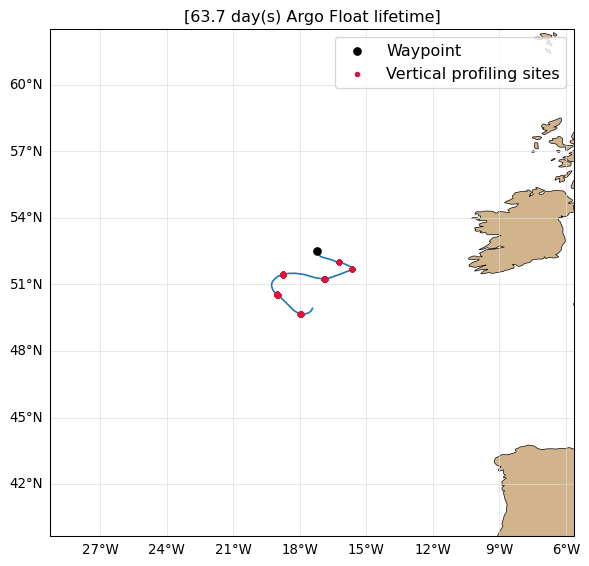

In [9]:
# fig
fig = plt.figure(figsize=(10, 6), dpi=96)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# plot trajectory
for i, traj in enumerate(argo_ds["trajectory"]):
    # extract trajectory data
    lons = argo_ds["lon"][:].sel(trajectory=traj).squeeze()
    lats = argo_ds["lat"][:].sel(trajectory=traj).squeeze()
    cycle_phase = argo_ds["cycle_phase"][:].sel(trajectory=traj).squeeze()

    # plot
    ax.plot(
        lons,
        lats,
        linestyle="-",
        linewidth=1.25,
        zorder=3,
        transform=ccrs.PlateCarree(),
    )

    # add release location
    MARKERSIZE = 30
    ax.scatter(
        lons[0],
        lats[0],
        marker="o",
        s=MARKERSIZE,
        color="black",
        zorder=4,
        transform=ccrs.PlateCarree(),
        label="Waypoint" if i == 0 else None,  # only label first for legend
    )

    # add marker where cycle_phase == 0 and temperature is not nan
    temp = argo_ds["temperature"][:].sel(trajectory=traj).squeeze()
    mask = ~np.isnan(temp)
    if np.any(mask):
        ax.scatter(
            np.array(lons)[mask],
            np.array(lats)[mask],
            s=10,
            color="crimson",
            zorder=5,
            transform=ccrs.PlateCarree(),
            label="Vertical profiling sites" if i == 0 else None,
        )


# additional map features
latlon_buffer = 10.0  # degrees (adjust this to 'zoom' in/out in the plot)
ax.set_extent(
    [
        argo_ds.lon.min() - latlon_buffer,
        argo_ds.lon.max() + latlon_buffer,
        argo_ds.lat.min() - latlon_buffer,
        argo_ds.lat.max() + latlon_buffer,
    ],
    crs=ccrs.PlateCarree(),
)
ax.coastlines(linewidth=0.5, color="black")
ax.add_feature(cfeature.LAND, facecolor="tan")
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color="gainsboro",
    alpha=1.0,
    linestyle="-",
    zorder=0,
)
gl.top_labels = False
gl.right_labels = False

ax.legend(loc="upper right", fontsize=12)

n_days = float(
    (argo_ds["time"][0].max(skipna=True) - argo_ds["time"][0].min(skipna=True))
    / np.timedelta64(1, "D")
)
plt.title(f"[{n_days:.1f} day(s) Argo Float lifetime]", fontsize=12)

plt.tight_layout()

### Argo float trajectory in 3D

We now bring the third dimension into the plot, showing the vertical movement of the Argo float(s) as they profile through the water column. The depth is represented on the z-axis, with surface level at the top of the plot and increasing depth downwards. The colour of the markers represents the depth as well, with darker colours indicating deeper.

You can see as the floats drift with the currents at depth, and then carry out their vertical profiling.

<div class="alert alert-block alert-success"> 
<b>**TIP**:</b> This 3D plot is interactive! You can click and drag to rotate the view, scroll to zoom in/out, and hover over points to see more information.
</div>

**Important**: This plot supports plotting only one Argo float/waypoint at a time. If you have deployed multiple Argo floats at different waypoints, you will need to make your selection via the `WHICH_ARGO` variable below. (Hint: you can see how many waypoints with Argo floats there are by running the cell immediately after this one first.)

In [10]:
print(
    f"There is/are {len(argo_ds['trajectory'])} Argo float(s) waypoints in this dataset."
)

There is/are 1 Argo float(s) waypoints in this dataset.


In [11]:
WHICH_ARGO = 0  # choose which Argo float to plot here (0-indexed); you can leave this if you only have one Argo float

In [12]:
fig = go.Figure()

traj = argo_ds["trajectory"][WHICH_ARGO]
lons = argo_ds["lon"][:].sel(trajectory=traj).squeeze()
lats = argo_ds["lat"][:].sel(trajectory=traj).squeeze()
depth = argo_ds["z"][:].sel(trajectory=traj).squeeze()

fig.add_trace(
    go.Scatter3d(
        x=lons,
        y=lats,
        z=depth,
        mode="markers",
        marker=dict(
            size=5,
            color=depth,
            colorscale="Viridis",
            colorbar=dict(title="Depth (m)", orientation="h", y=-0.25, x=0.5),
            opacity=0.8,
        ),
        name=f"Argo {WHICH_ARGO + 1}",
    )
)

n_days = float(
    (argo_ds["time"][0].max(skipna=True) - argo_ds["time"][0].min(skipna=True))
    / np.timedelta64(1, "D")
)

fig.update_layout(
    scene=dict(
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        zaxis_title="Depth (m)",
        yaxis=dict(autorange="reversed"),  # north is up from plot viewpoint
    ),
    width=800,
    height=800,
    title=f"Argo Float (#{WHICH_ARGO + 1}) [{n_days:.1f} day lifetime]",
)

html_str = pio.to_html(fig, include_plotlyjs="cdn")
display(HTML(html_str))

### Argo float vertical sampling

Let's now have a look at the vertical profiles of temperature and salinity collected by the Argo floats during the expedition. We can produce plots for each variable, showing how they vary with depth. 

Choose below which variable you would like to plot by setting the `PLOT_VARIABLE` variable to either `"temperature"` or `"salinity"`.

The vertical profiles are recorded by the Argo float at each of the ascent/descent locations we've seen in the previous 3D plot. This time the drift periods are not shown.

<div class="alert alert-block alert-success"> 
<b>**TIP**:</b> Don't forget to change the 'WHICH_ARGO' variable above if you want to visualise a different Argo float profile from your results (if you have multiple deployed)!
</div>

In [13]:
PLOT_VARIABLE = "temperature"  # options: 'temperature', 'salinity'

In [14]:
fig = go.Figure()

VARIABLES = {
    "temperature": {
        "cmap": "Inferno",
        "label": "Temperature (°C)",
        "ds_name": "temperature",
    },
    "salinity": {
        "cmap": "haline",
        "label": "Salinity (psu)",
        "ds_name": "salinity",
    },
}

traj = argo_ds["trajectory"][WHICH_ARGO]
lons = argo_ds["lon"][:].sel(trajectory=traj).squeeze()
lats = argo_ds["lat"][:].sel(trajectory=traj).squeeze()
depth = argo_ds["z"][:].sel(trajectory=traj).squeeze()
var = argo_ds[VARIABLES[PLOT_VARIABLE]["ds_name"]][:].sel(trajectory=traj).squeeze()

# mask out NaNs (temp/salinity not recorded when drifting)
mask = ~np.isnan(var)
lons = np.array(lons)[mask]
lats = np.array(lats)[mask]
depth = np.array(depth)[mask]
var = np.array(var)[mask]

fig.add_trace(
    go.Scatter3d(
        x=lons,
        y=lats,
        z=depth,
        mode="markers",
        marker=dict(
            size=5,
            color=var,
            colorscale=VARIABLES[PLOT_VARIABLE]["cmap"],
            colorbar=dict(
                title=VARIABLES[PLOT_VARIABLE]["label"], orientation="h", y=-0.25, x=0.5
            ),
            opacity=0.8,
        ),
        name=f"Argo {WHICH_ARGO + 1}",
        customdata=np.stack([var], axis=-1),
        hovertemplate=(
            "Lon: %{x:.3f}<br>"
            "Lat: %{y:.3f}<br>"
            "Depth: %{z:.1f} m<br>"
            f"{VARIABLES[PLOT_VARIABLE]['label']}: "
            + "%{customdata[0]:.3f}<extra></extra>"
        ),
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        zaxis_title="Depth (m)",
        yaxis=dict(autorange="reversed"),  # north is up from plot viewpoint
    ),
    width=800,
    height=800,
    title=f"Argo Float (#{WHICH_ARGO + 1}) [{n_days:.1f} day lifetime]",
)

html_str = pio.to_html(fig, include_plotlyjs="cdn")
display(HTML(html_str))